In [21]:
%pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
import re,os,sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
rating_df=pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
if 'source_id' in rating_df.columns:
    rating_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in rating_df.columns:
    rating_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
rating_df = rating_df.dropna(axis=0)
domain_locations_df = domain_locations_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge_df=pd.merge(rating_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge_df=pd.merge(merge_df, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

Number of events: 10
News sites reporting events earliest:
 source_name
Android Central                 2023-10-01 20:00:46.000000
Al Jazeera English              2023-10-01 20:22:17.000000
Deadline                        2023-10-01 23:35:34.000000
BBC News                        2023-10-02 00:04:05.000000
Business Insider                2023-10-02 00:10:25.000000
RT                              2023-10-02 01:32:33.000000
Forbes                          2023-10-02 02:03:15.000000
The Indian Express              2023-10-02 02:04:23.000000
International Business Times    2023-10-02 02:45:30.000000
Time                            2023-10-02 05:00:00.000000
GlobeNewswire                   2023-10-02 05:30:00.000000
The Times of India              2023-10-02 06:42:03.000000
Phys.Org                        2023-10-02 07:30:39.000000
Globalsecurity.org              2023-10-02 08:07:51.000000
Marketscreener.com              2023-10-02 08:16:05.000000
NPR                             2023-10-02 

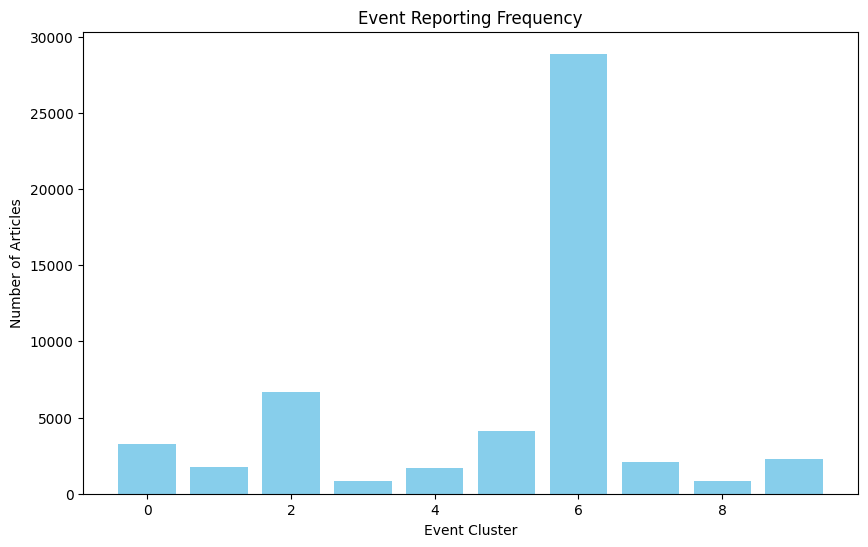

In [30]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    # Join the filtered tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

merge_df['preprocessed_content'] = merge_df['content'].apply(preprocess_text)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(merge_df['preprocessed_content'])

#  Clustering
num_clusters = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)


merge_df['cluster'] = kmeans.labels_

# Count the number of events covered in the data
num_events = merge_df['cluster'].nunique()
print("Number of events:", num_events)

# Determine which news sites report events the earliest
earliest_reporting = merge_df.groupby('source_name')['published_at'].min()
earliest_reporting = earliest_reporting.sort_values()
print("News sites reporting events earliest:\n", earliest_reporting)

event_counts = merge_df['cluster'].value_counts()
print("Event reporting frequency:\n", event_counts)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values, color='skyblue')
plt.xlabel('Event Cluster')
plt.ylabel('Number of Articles')
plt.title('Event Reporting Frequency')
plt.show()


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

rating_df=pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
if 'source_id' in rating_df.columns:
    rating_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in rating_df.columns:
    rating_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
rating_df = rating_df.dropna(axis=0)
domain_locations_df = domain_locations_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge=pd.merge(rating_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge=pd.merge(merge, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

# Preprocess the text data
# You can use your existing preprocess_text function or define a new one here
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# merge_df['processed_title'] = merge_df['title'].apply(preprocess_text)
# merge_df['processed_content'] = merge_df['content'].apply(preprocess_text)
# merge_df['combined_text'] = merge_df['processed_title'] + ' ' + merge_df['processed_content']


sample_size = 1000  # Adjust the sample size as needed
merge_df= merge.sample(n=sample_size, random_state=42)


# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(merge_df['content'])

X_sparse = csr_matrix(X)
cosine_sim_matrix = cosine_similarity(X_sparse)
similarity_threshold = 0.5

# Fit LDA model
num_topics = 10  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Assign topics to articles
merge_df['topic'] = lda_model.transform(X).argmax(axis=1)

# Calculate pairwise cosine similarity between articles
cosine_sim_matrix = cosine_similarity(X)

# Threshold for considering articles as related (adjust as needed)
similarity_threshold = 0.5

# Function to detect events based on similarity of articles
def detect_events(article_index):
    related_articles = set()
    for i, similarity_score in enumerate(cosine_sim_matrix[article_index]):
        if similarity_score > similarity_threshold:
            related_articles.add(i)
    return related_articles

# Apply event detection to each article in the sampled subset
merge_df['related_articles'] = merge_df.index.map(detect_events)

# Explore the detected events
for event_id, event_articles in enumerate(merge_df['related_articles']):
    print(f"Event {event_id}:")
    for article_index in event_articles:
        if article_index < len(merge_df):  # Check if the index is within bounds
            article = merge_df.iloc[article_index][['title', 'content']]
            print(article)
    print()




IndexError: index 2830 is out of bounds for axis 0 with size 1000

In [ ]:
if __name__ == "__main__":
    data_directory = "../data"
    loader = NewsDataLoader(data_directory)

    merge_df = loader.load_data()

print(merge_df.columns)

Index(['article_id', 'source_name', 'author', 'title', 'description', 'url',
       'published_at', 'content', 'category', 'article', 'title_sentiment',
       'SourceCommonName', 'location', 'Country', 'GlobalRank', 'TldRank',
       'Domain', 'TLD', 'RefSubNets', 'RefIPs', 'IDN_Domain', 'IDN_TLD',
       'PrevGlobalRank', 'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object')


In [ ]:
# Preprocessing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import Tfimerge_dfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Load data
# Assuming you have already loaded the data into a DataFrame called 'merge_df'

# Preprocess text data
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Implement your preprocessing steps here
    return preprocessed_text

merge_df['clean_content'] = merge_df['content'].apply(preprocess_text)

# Feature Extraction
tfimerge_df_vectorizer = Tfimerge_dfVectorizer(stop_words='english')
tfimerge_df_matrix = tfimerge_df_vectorizer.fit_transform(merge_df['clean_content'])

# Clustering
num_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfimerge_df_matrix)
clusters = kmeans.labels_

# Event Identification
merge_df['cluster'] = clusters

# Earliest Reporting
earliest_reporting = merge_df.groupby('cluster')['published_at'].min()

# Event Frequency
event_frequency = merge_df['cluster'].value_counts()

# Correlation Analysis
correlation_matrix = merge_df.groupby(['source_name', 'cluster']).size().unstack(fill_value=0).corr()

# Analyze results
# You can further analyze the clusters, earliest reporting, event frequency, and correlation matrix to answer the questions.

# Example: Print the number of events covered in the data
num_events = len(merge_df['cluster'].unique())
print("Number of events covered:", num_events)

# Example: Print news sites reporting events earliest
print("Earliest reporting  by news sites:")
print(earliest_reporting)

# Example: Print events with the highest reporting
print("Events with the highest reporting:")
print(event_frequency)

# Example: Print correlation matrix between news sites reporting events
print("Correlation matrix:")
print(correlation_matrix)
